In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/fraud-detection/fraudTest.csv
/kaggle/input/fraud-detection/fraudTrain.csv


In [2]:
import pandas as pd

train = pd.read_csv('/kaggle/input/fraud-detection/fraudTrain.csv')
test = pd.read_csv('/kaggle/input/fraud-detection/fraudTrain.csv')

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (1296675, 23)
Test shape: (1296675, 23)


In [3]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.info()

Train shape: (1296675, 23)
Test shape: (1296675, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                

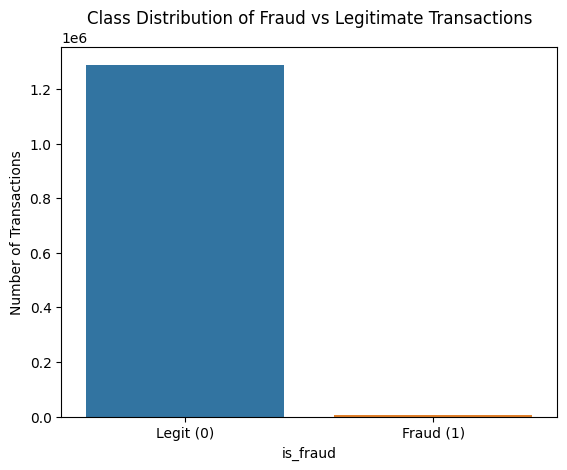

Fraudulent transactions: 0.5789%


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=train, x='is_fraud')
plt.title("Class Distribution of Fraud vs Legitimate Transactions")
plt.xticks([0, 1], ['Legit (0)', 'Fraud (1)'])
plt.ylabel('Number of Transactions')
plt.show()

fraud_ratio = train['is_fraud'].value_counts(normalize=True) * 100
print(f"Fraudulent transactions: {fraud_ratio[1]:.4f}%")


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


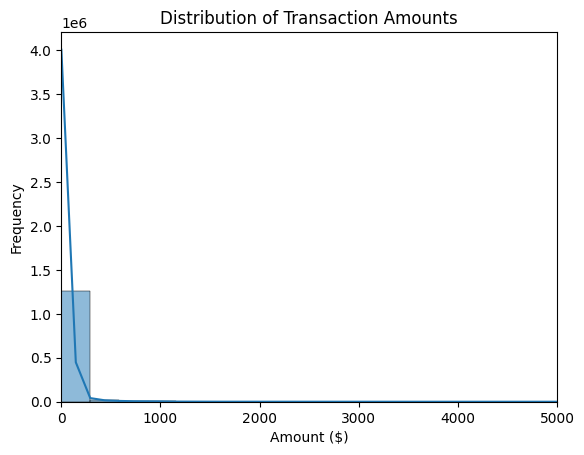

In [5]:
sns.histplot(train['amt'], bins=100, kde=True)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Amount ($)")
plt.ylabel("Frequency")
plt.xlim(0, 5000)  # limit outliers
plt.show()


In [6]:
# Convert to datetime
train['trans_date_trans_time'] = pd.to_datetime(train['trans_date_trans_time'], errors='coerce')
train['dob'] = pd.to_datetime(train['dob'], errors='coerce')

# Compute age
train['age'] = train['trans_date_trans_time'].dt.year - train['dob'].dt.year


In [7]:
train['hour'] = train['trans_date_trans_time'].dt.hour
train['weekday'] = train['trans_date_trans_time'].dt.dayofweek



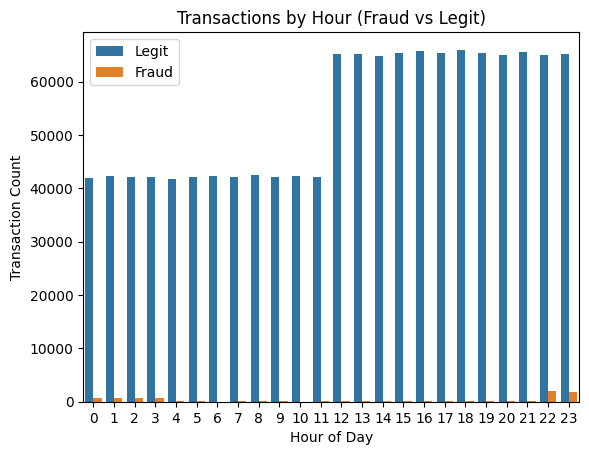

In [8]:
sns.countplot(data=train, x='hour', hue='is_fraud')
plt.title("Transactions by Hour (Fraud vs Legit)")
plt.xlabel("Hour of Day")
plt.ylabel("Transaction Count")
plt.legend(['Legit', 'Fraud'])
plt.show()


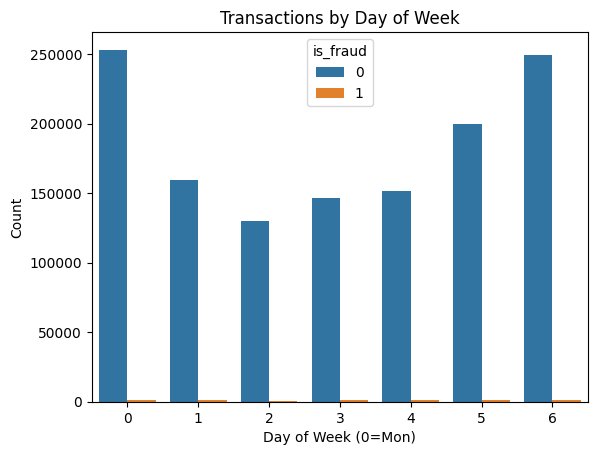

In [9]:
sns.countplot(data=train, x='weekday', hue='is_fraud')
plt.title("Transactions by Day of Week")
plt.xlabel("Day of Week (0=Mon)")
plt.ylabel("Count")
plt.show()


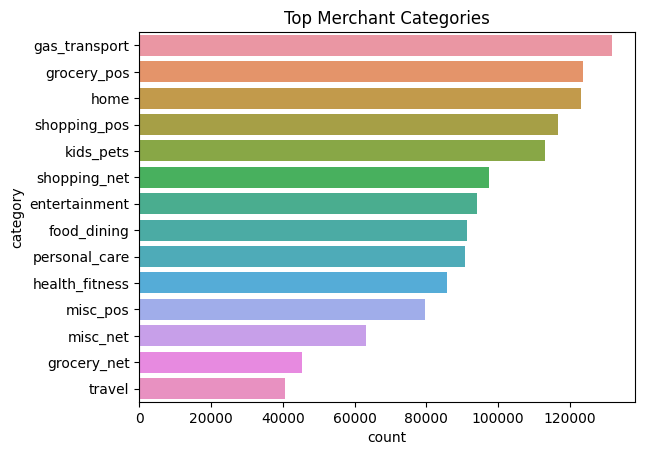

In [10]:
sns.countplot(y='category', data=train, order=train['category'].value_counts().index)
plt.title("Top Merchant Categories")
plt.show()


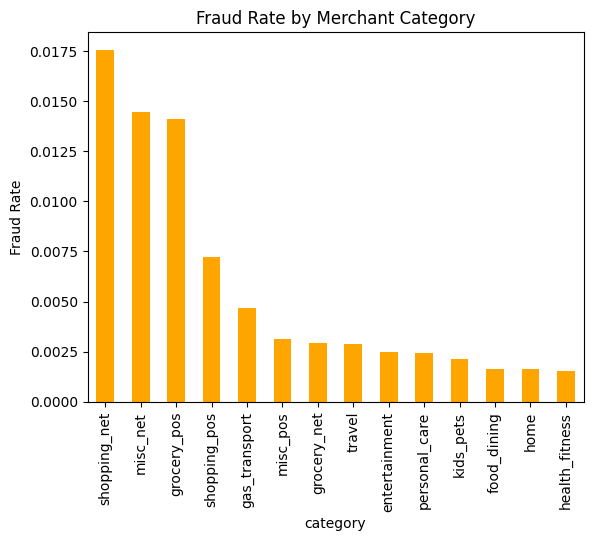

In [11]:
fraud_by_cat = train.groupby('category')['is_fraud'].mean().sort_values(ascending=False)
fraud_by_cat.plot(kind='bar', color='orange')
plt.title("Fraud Rate by Merchant Category")
plt.ylabel("Fraud Rate")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


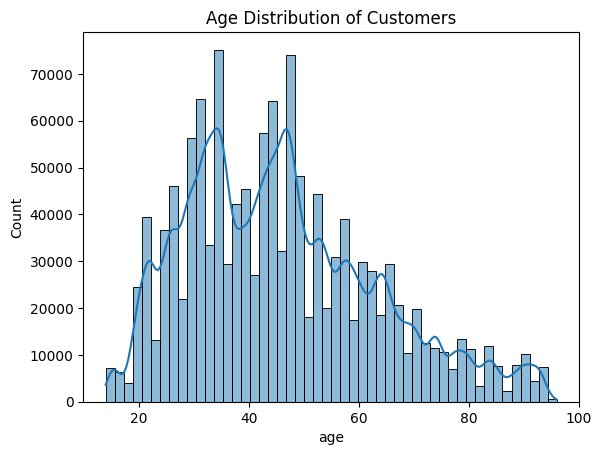

In [12]:
train['age'] = train['trans_date_trans_time'].dt.year - train['dob'].dt.year
sns.histplot(train['age'], bins=50, kde=True)
plt.title("Age Distribution of Customers")
plt.show()


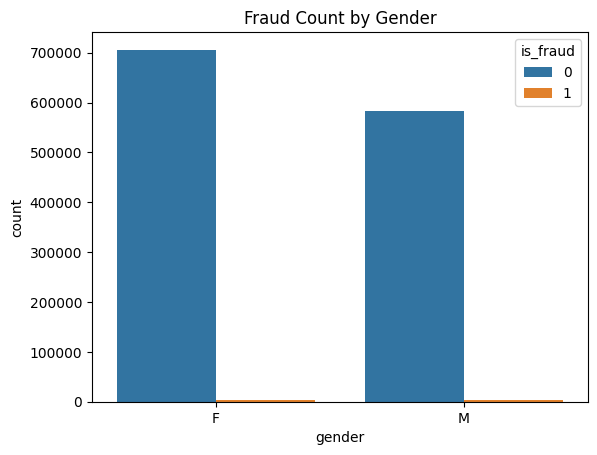

In [13]:
sns.countplot(x='gender', hue='is_fraud', data=train)
plt.title("Fraud Count by Gender")
plt.show()


In [14]:
import folium
from folium.plugins import HeatMap

sample = train[train['is_fraud'] == 1].sample(1000)
m = folium.Map(location=[sample['lat'].mean(), sample['long'].mean()], zoom_start=5)
HeatMap(sample[['lat', 'long']]).add_to(m)
m


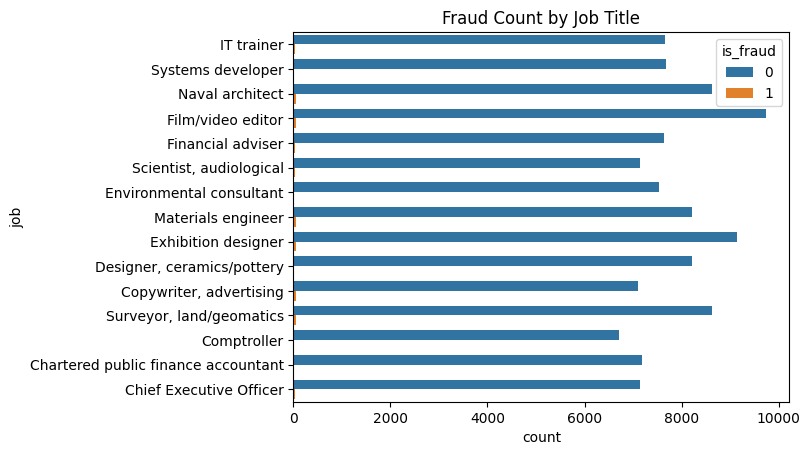

In [15]:
top_jobs = train['job'].value_counts().nlargest(15).index
subset = train[train['job'].isin(top_jobs)]

sns.countplot(data=subset, y='job', hue='is_fraud')
plt.title("Fraud Count by Job Title")
plt.show()


In [16]:
from geopy.distance import geodesic

def calc_distance(row):
    try:
        return geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).km
    except:
        return None

train['distance'] = train.apply(calc_distance, axis=1)

In [17]:
card_tx_count = train.groupby('cc_num').size()
train['tx_per_card'] = train['cc_num'].map(card_tx_count)


In [18]:
fraud_rate = train.groupby('merchant')['is_fraud'].mean()
train['merchant_fraud_rate'] = train['merchant'].map(fraud_rate)


In [19]:
features = [
    'amt', 'age', 'hour', 'weekday', 'distance',
    'tx_per_card', 'merchant_fraud_rate'
] + list(train.columns[train.columns.str.startswith(('gender_', 'category_', 'job_'))])

X = train[features]
y = train['is_fraud']

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)

print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99    257834
           1       0.21      0.94      0.34      1501

    accuracy                           0.98    259335
   macro avg       0.60      0.96      0.66    259335
weighted avg       1.00      0.98      0.99    259335

[[252454   5380]
 [    97   1404]]


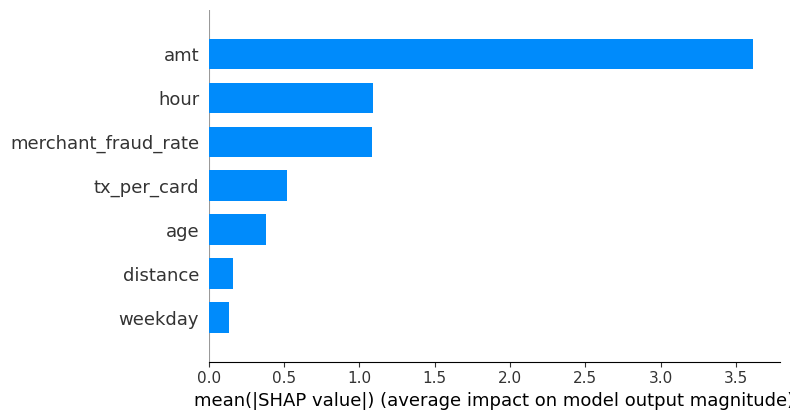

In [21]:
import shap

explainer = shap.Explainer(xgb)
shap_values = explainer(X_val.sample(1000))

shap.summary_plot(shap_values, X_val.sample(1000), plot_type='bar')


In [22]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
import pandas as pd

# Train LightGBM model
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_val)
lgbm_report = classification_report(y_val, y_pred_lgbm, output_dict=True)['1']

# Display as DataFrame
lgbm_results = pd.DataFrame([lgbm_report])
lgbm_results['Model'] = 'LightGBM'
lgbm_results = lgbm_results[['Model', 'precision', 'recall', 'f1-score', 'support']]

# Print nicely in Kaggle without ace_tools
print("📊 LightGBM Model Evaluation (Fraud Class Only)")
print(lgbm_results.to_string(index=False))


[LightGBM] [Info] Number of positive: 6005, number of negative: 1031335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1126
[LightGBM] [Info] Number of data points in the train set: 1037340, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005789 -> initscore=-5.146017
[LightGBM] [Info] Start training from score -5.146017
📊 LightGBM Model Evaluation (Fraud Class Only)
   Model  precision   recall  f1-score  support
LightGBM   0.710145 0.587608  0.643092     1501


In [23]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
import pandas as pd

# Train CatBoost model
catboost = CatBoostClassifier(verbose=0, random_state=42)
catboost.fit(X_train, y_train)
y_pred_cat = catboost.predict(X_val)
cat_report = classification_report(y_val, y_pred_cat, output_dict=True)['1']

# Format result
catboost_results = pd.DataFrame([cat_report])
catboost_results['Model'] = 'CatBoost'
catboost_results = catboost_results[['Model', 'precision', 'recall', 'f1-score', 'support']]

catboost_results


,Model,precision,recall,f1-score,support
0,CatBoost,0.884917,0.676216,0.766616,1501


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd

# Train Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
rf_report = classification_report(y_val, y_pred_rf, output_dict=True)['1']

# Format result
rf_results = pd.DataFrame([rf_report])
rf_results['Model'] = 'Random Forest'
rf_results = rf_results[['Model', 'precision', 'recall', 'f1-score', 'support']]

rf_results


,Model,precision,recall,f1-score,support
0,Random Forest,0.89296,0.616922,0.729708,1501


In [25]:
from sklearn.calibration import CalibratedClassifierCV

# Re-train model with calibration
calibrated_model = CalibratedClassifierCV(base_estimator=xgb, method='isotonic', cv=3)
calibrated_model.fit(X_train, y_train)

# Predict calibrated probabilities
y_proba_calibrated = calibrated_model.predict_proba(X_val)[:, 1]

# Use threshold 0.7 again
y_pred_calibrated = (y_proba_calibrated >= 0.7).astype(int)

print("📐 Calibrated Model (Threshold = 0.7):")
print(classification_report(y_val, y_pred_calibrated))

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


📐 Calibrated Model (Threshold = 0.7):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.92      0.55      0.69      1501

    accuracy                           1.00    259335
   macro avg       0.96      0.78      0.85    259335
weighted avg       1.00      1.00      1.00    259335



In [27]:
"""import joblib
joblib.dump(calibrated_model, "xgb_model.pkl")"""

['xgb_model.pkl']

In [29]:
"""import pickle

# Save feature names, encoders, etc.
metadata = {
    'features': X_train.columns.tolist(),
    'mean_tx_per_card': train['tx_per_card'].mean(),  # use 'train' instead of 'df'
    'merchant_fraud_rate': train.groupby('merchant')['is_fraud'].mean().to_dict()
}


with open("preprocessing_metadata.pkl", "wb") as f:
    pickle.dump(metadata, f)"""


'import pickle\n\n# Save feature names, encoders, etc.\nmetadata = {\n    \'features\': X_train.columns.tolist(),\n    \'mean_tx_per_card\': train[\'tx_per_card\'].mean(),  # use \'train\' instead of \'df\'\n    \'merchant_fraud_rate\': train.groupby(\'merchant\')[\'is_fraud\'].mean().to_dict()\n}\n\n\nwith open("preprocessing_metadata.pkl", "wb") as f:\n    pickle.dump(metadata, f)'

In [26]:

import pandas as pd
import numpy as np
from geopy.distance import geodesic
from sklearn.metrics import classification_report, accuracy_score
# assume xgb, calibrated_model, lgbm, catboost, rf are already in memory

# 1) Load test set
test = pd.read_csv("/kaggle/input/fraud-detection/fraudTest.csv")


test["trans_date_trans_time"] = pd.to_datetime(test["trans_date_trans_time"], errors="coerce")
test["dob"] = pd.to_datetime(test["dob"], errors="coerce")
test["age"] = test["trans_date_trans_time"].dt.year - test["dob"].dt.year
test["hour"] = test["trans_date_trans_time"].dt.hour
test["weekday"] = test["trans_date_trans_time"].dt.dayofweek








In [27]:
# 3) Geographic distance
def calc_distance(r):
    try:
        return geodesic((r["lat"], r["long"]),
                        (r["merch_lat"], r["merch_long"])).km
    except:
        return 0.0

test["distance"] = test.apply(calc_distance, axis=1)


test["tx_per_card"] = test["cc_num"].map(test["cc_num"].value_counts())
train = pd.read_csv("/kaggle/input/fraud-detection/fraudTrain.csv")  # to get fraud rates
fraud_rate_map      = train.groupby("merchant")["is_fraud"].mean().to_dict()
test["merchant_fraud_rate"] = test["merchant"].map(fraud_rate_map).fillna(0)

In [30]:


# 5. Save the target column
y_test = test['is_fraud']

# 6. One-hot encode categorical variables
test = pd.get_dummies(test, columns=['gender', 'category', 'job'], drop_first=True)

# 7. Match test features to train model input
X_test = test.reindex(columns=X_train.columns, fill_value=0)

# 8. Predict and evaluate **for each model**

models = {
    'XGBoost (raw)'        : xgb,
    'XGBoost (calibrated)' : calibrated_model,
    'LightGBM'             : lgbm,
    'CatBoost'             : catboost,
    'RandomForest'         : rf
}




In [31]:
for name, mdl in models.items():
    print(f"\n==== {name} ====")
    y_pred = mdl.predict(X_test)
    print("📊 Classification Report:\n")
    print(classification_report(y_test, y_pred))
    print("🧾 Confusion Matrix:\n")
    print(confusion_matrix(y_test, y_pred))


==== XGBoost (raw) ====
📊 Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.91      0.96    553574
           1       0.04      0.95      0.08      2145

    accuracy                           0.91    555719
   macro avg       0.52      0.93      0.52    555719
weighted avg       1.00      0.91      0.95    555719

🧾 Confusion Matrix:

[[506082  47492]
 [   110   2035]]

==== XGBoost (calibrated) ====
📊 Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    553574
           1       0.27      0.75      0.40      2145

    accuracy                           0.99    555719
   macro avg       0.64      0.87      0.70    555719
weighted avg       1.00      0.99      0.99    555719

🧾 Confusion Matrix:

[[549315   4259]
 [   546   1599]]

==== LightGBM ====
📊 Classification Report:

              precision    recall  f1-score   support

           0       1.00 

In [32]:
rows = []
for name, m in models.items():
    y_pred = m.predict(X_test)
    acc    = accuracy_score(y_test, y_pred)
    rep    = classification_report(y_test, y_pred, output_dict=True).get("1", {})
    rows.append({
        "Model":       name,
        "Accuracy":    round(acc,       4),
        "Precision@fraud": round(rep.get("precision",0), 4),
        "Recall@fraud":    round(rep.get("recall",   0), 4),
        "F1@fraud":        round(rep.get("f1-score", 0), 4),
        "Support@fraud":   int(rep.get("support",   0))
    })

comp_df = pd.DataFrame(rows).set_index("Model")
comp_df

# %%
# 8) Persist comparison
comp_df.to_csv("model_comparison.csv")
comp_df.to_pickle("model_comparison.pkl")
print("✅ Wrote model_comparison.csv & .pkl")

✅ Wrote model_comparison.csv & .pkl


FixedFormatter should only be used together with FixedLocator


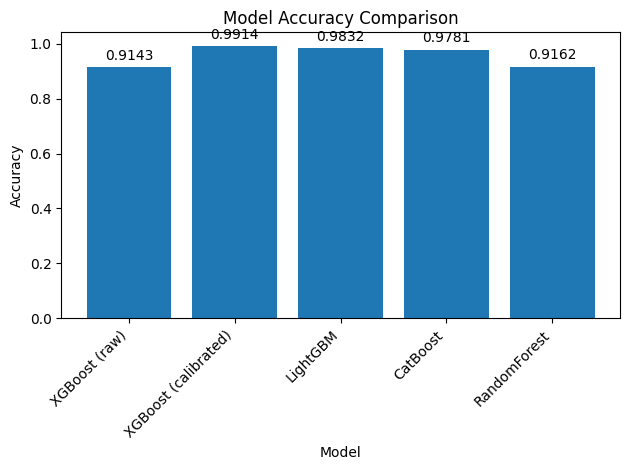

FixedFormatter should only be used together with FixedLocator


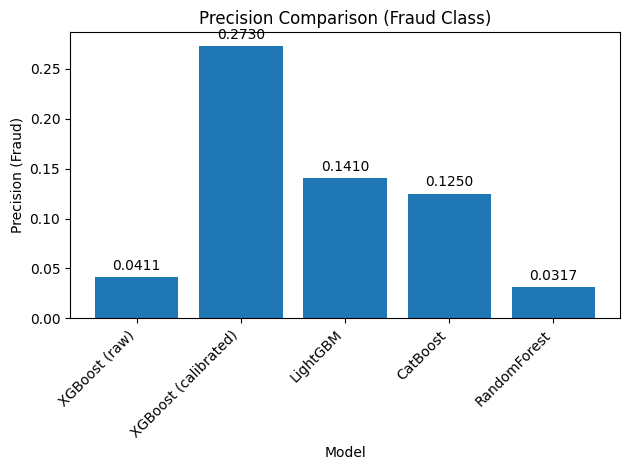

FixedFormatter should only be used together with FixedLocator


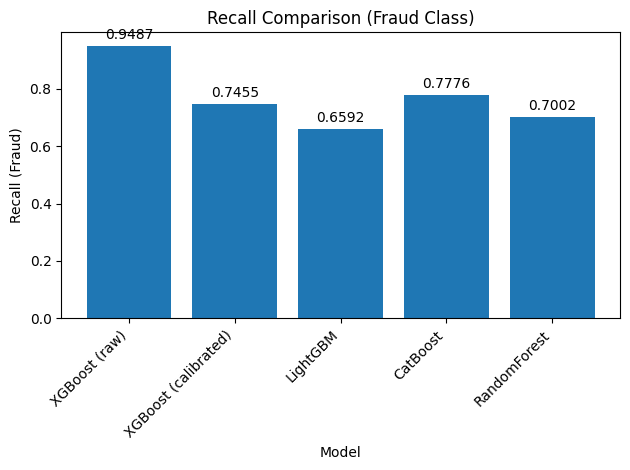

FixedFormatter should only be used together with FixedLocator


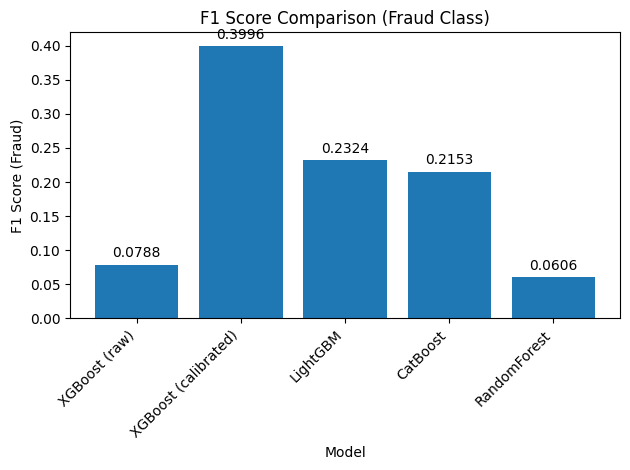

In [34]:
import matplotlib.pyplot as plt

def annotate_bars(ax, fmt="%.2f"):
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(
            fmt % height,
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  
            textcoords="offset points",
            ha="center", va="bottom"
        )

# Plot 1: Accuracy
fig, ax = plt.subplots()
ax.bar(comp_df.index, comp_df["Accuracy"])
ax.set_xlabel("Model")
ax.set_ylabel("Accuracy")
ax.set_title("Model Accuracy Comparison")
ax.set_xticklabels(comp_df.index, rotation=45, ha="right")
annotate_bars(ax, fmt="%.4f")
plt.tight_layout()
plt.show()

# Plot 2: Precision@fraud
fig, ax = plt.subplots()
ax.bar(comp_df.index, comp_df["Precision@fraud"])
ax.set_xlabel("Model")
ax.set_ylabel("Precision (Fraud)")
ax.set_title("Precision Comparison (Fraud Class)")
ax.set_xticklabels(comp_df.index, rotation=45, ha="right")
annotate_bars(ax, fmt="%.4f")
plt.tight_layout()
plt.show()

# Plot 3: Recall@fraud
fig, ax = plt.subplots()
ax.bar(comp_df.index, comp_df["Recall@fraud"])
ax.set_xlabel("Model")
ax.set_ylabel("Recall (Fraud)")
ax.set_title("Recall Comparison (Fraud Class)")
ax.set_xticklabels(comp_df.index, rotation=45, ha="right")
annotate_bars(ax, fmt="%.4f")
plt.tight_layout()
plt.show()

# Plot 4: F1@fraud
fig, ax = plt.subplots()
ax.bar(comp_df.index, comp_df["F1@fraud"])
ax.set_xlabel("Model")
ax.set_ylabel("F1 Score (Fraud)")
ax.set_title("F1 Score Comparison (Fraud Class)")
ax.set_xticklabels(comp_df.index, rotation=45, ha="right")
annotate_bars(ax, fmt="%.4f")
plt.tight_layout()
plt.show()


In [35]:
import matplotlib.pyplot as plt


comp_df["Composite"] = (
    comp_df["Precision@fraud"] +
    comp_df["Recall@fraud"] +
    comp_df["F1@fraud"]
) / 3

# 2) sort by that score
comp_sorted = comp_df.sort_values("Composite", ascending=False)

# 3) add a Rank column (1 = best)
comp_sorted["Rank"] = range(1, len(comp_sorted) + 1)

print(comp_sorted[["Rank", "Composite"]])


                      Rank  Composite
Model                                
XGBoost (calibrated)     1   0.472700
CatBoost                 2   0.372633
XGBoost (raw)            3   0.356200
LightGBM                 4   0.344200
RandomForest             5   0.264167


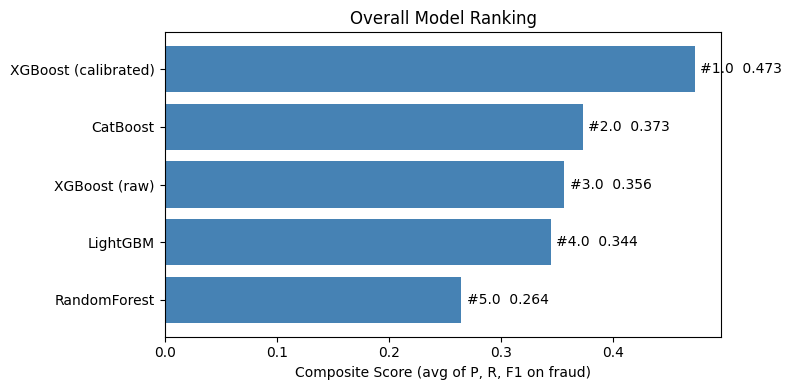

In [36]:
fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.barh(
    comp_sorted.index,
    comp_sorted["Composite"],
    color="steelblue"
)

ax.set_xlabel("Composite Score (avg of P, R, F1 on fraud)")
ax.set_title("Overall Model Ranking")
ax.invert_yaxis()  # highest score on top

# annotate each bar with the exact composite value and rank
for bar, (idx, row) in zip(bars, comp_sorted.iterrows()):
    ax.text(
        bar.get_width() + 0.005,
        bar.get_y() + bar.get_height() / 2,
        f"#{row.Rank}  {row.Composite:.3f}",
        va="center"
    )

plt.tight_layout()
plt.show()
